# Импорт библиотек

In [7]:
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [8]:
from bs4 import BeautifulSoup

In [9]:
from collections import Counter
from typing import List, Dict

In [10]:
from PIL import Image
import cv2

In [11]:
import os
from glob import glob

In [1]:
import pytesseract
import easyocr

## Константы

In [5]:
seed = 42
train_dataset_path = "./Data/train"
test_dataset_path = "./Data/test"
pytesseract.pytesseract.tesseract_cmd = './Tesseract-OCR/tesseract.exe'
tesseract_configs = r'--oem 3 --psm 6 -l eng'
reader = easyocr.Reader(['ar', 'en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [12]:
# Список всех файлов jpeg в обучающей выборке и тестовой
train_jpeg_files = glob(train_dataset_path + '/*.jpeg')
test_jpeg_files = glob(test_dataset_path + '/*.jpeg')

# Разведочный анализ данных

In [104]:
# Проверим, сколько уникальных форматов файлов хранится в данных
set(map(lambda x: x.split('.')[-1], os.listdir(train_dataset_path)))

{'jpeg', 'png', 'txt', 'xml'}

In [31]:
# Отсортируем данные обучающей выборки по названиям файлов
train_folder = [x for x in sorted(os.listdir(train_dataset_path)) if not x.endswith('.txt')]

In [32]:
# Словарь, где ключ - путь до картинки, значение - путь до xml файла выбранной картинки
data_dict = {}
for i in range(0, len(train_folder), 2):
    data_dict[train_folder[i]] = train_folder[i+1]

In [140]:
list(data_dict.items())[:3]

[('ckictsenl0000246a2itn28ts.jpeg', 'ckictsenl0000246a2itn28ts.xml'),
 ('ckictw05s0001246aeel6cew4.jpeg', 'ckictw05s0001246aeel6cew4.xml'),
 ('ckictycsy0002246ajt63dkm5.jpeg', 'ckictycsy0002246ajt63dkm5.xml')]

## Визуализация примеров данных

In [26]:
def visualize_data(data: Dict[str, str], N: int):
    # Путь до данных
    path = train_dataset_path + '/'

    # Отдельно запишем ключи словаря
    keys = list(data.keys())
    
    plt.figure(figsize=(20, N / 2))
    
    for i in range(N):
        plt.subplot(ceil(N / 5), 5, i+1)
        plt.axis('Off')
        # JPEG
        key = np.random.choice(keys)
        # XML
        with open(path + data[key], 'r') as file:
            xml_data = BeautifulSoup(file, 'xml')
            # Цифры со знака на картинке
            label = ''.join([x.text for x in xml_data.find_all('name')])
        
        image = plt.imread(path + key)
        plt.imshow(image)
        plt.title(f"Номер знака: {label}", pad=12)
    
    plt.show()

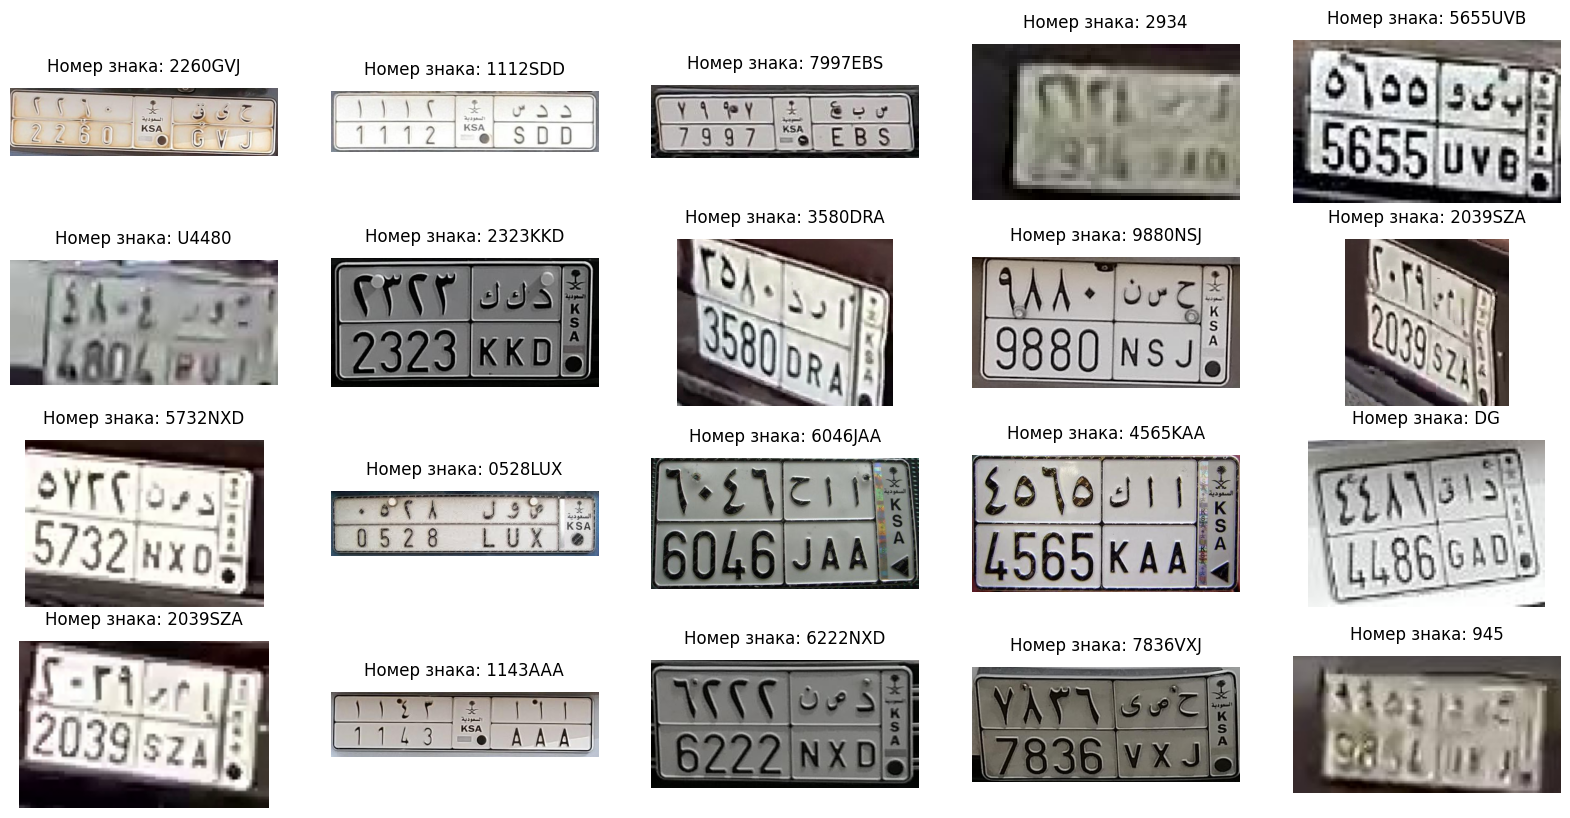

In [163]:
visualize_data(data=data_dict, N=20)

## Визуализация распределения классов в обучающей выборке

In [17]:
# Записываем в список все xml файлы для определения распределения классов из обучающей выборки
train_xml_files = glob(train_dataset_path + '/*.xml')

In [117]:
# Кол-во различных классов (символов)
counter = Counter()

for i in range(len(train_xml_files)):
    with open(train_xml_files[i], 'r') as f:
        data = f.read()

    counter.update([x.text for x in BeautifulSoup(data, "xml").find_all('name')])

In [136]:
# Топ 5 самых встречающихся классов в обучающей выборке
dict(counter.most_common(5))

{'7': 260, '3': 257, '5': 242, '2': 233, 'J': 233}

In [155]:
# Итоговое распределение всех классов
dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

{'7': 260,
 '3': 257,
 '5': 242,
 '2': 233,
 'J': 233,
 '0': 220,
 '4': 208,
 '9': 191,
 'D': 190,
 '8': 175,
 '6': 173,
 'B': 165,
 'A': 157,
 '1': 156,
 'N': 102,
 'X': 83,
 'L': 70,
 'Z': 69,
 'V': 66,
 'S': 64,
 'T': 58,
 'R': 47,
 'K': 46,
 'H': 46,
 'G': 45,
 'E': 37,
 'U': 35}

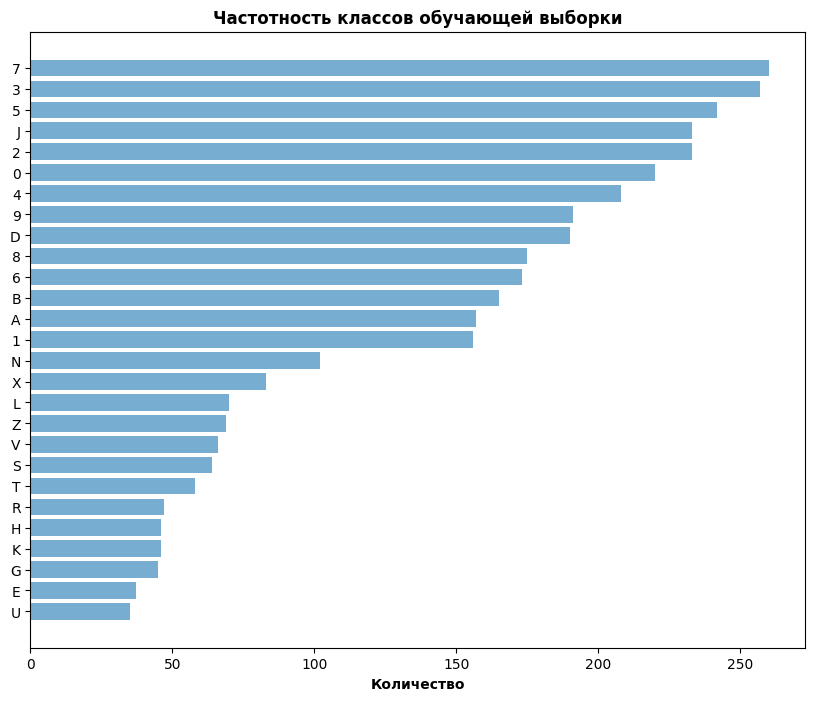

In [208]:
# График распределения классов обучающей выборки
ordered = dict(sorted(counter.items(), key=lambda item: item[1]))
keys = ordered.keys()
y_pos = np.arange(len(keys))
counts = [ordered[k] for k in keys]

plt.figure(figsize=(10, 8))
plt.barh(y_pos, counts, align='center', alpha=0.6)
plt.yticks(y_pos, keys)
plt.xlabel('Количество', weight='bold')
plt.title('Частотность классов обучающей выборки', weight='bold', fontsize=12)

plt.show()

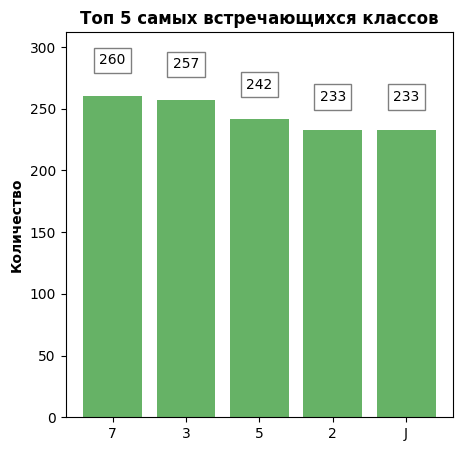

In [207]:
# Топ 5 самых популярных классов
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.1 * y[i], y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha =.5, lw=1))


ordered = dict(sorted(counter.most_common(5), key=lambda item: item[1], reverse=True))
keys = ordered.keys()
y_pos = np.arange(len(keys))
counts = [ordered[k] for k in keys]

fig, ax = plt.subplots(figsize=(5, 5))

addlabels(y_pos, counts)
plt.bar(y_pos, counts, align='center', alpha=0.6, color = 'g')
plt.xticks(y_pos, keys)
ax.set_ylim([0,max(counts) + 0.2 * max(counts)])
plt.ylabel('Количество', weight='bold')
plt.title('Топ 5 самых встречающихся классов', weight='bold', fontsize=12)

plt.show()

## Базовая модель Tesseract от компании Google

**Tesseract-OCR** — это движок оптического распознавания символов (OCR) с открытым исходным кодом, является самой популярной и качественной OCR-библиотекой.

In [57]:
# Определение символов на знаках базовой моделью Tesseract
def draw_boxes_tesseract(img_file_name: str, tesseract_configs: str = tesseract_configs):
    # Считываем изображение
    img = cv2.imread(img_file_name)
    # Размеры изображения
    hImg, _, _ = img.shape
    boxes = pytesseract.image_to_boxes(img,
                                       config=tesseract_configs)
    for i in boxes.splitlines():
        i = i.split(' ')
        
        x, y, w, h = int(i[1]), int(i[2]), int(i[3]), int(i[4])
        
        # Нанесение границ вокруг предсказанного символа
        cv2.rectangle(img, (x, hImg - y), (w, hImg - h), (0, 0, 255), 1)

    return img

In [78]:
def visualize_base_tesseract_preds(data: List[str], N: int = 10, tesseract_configs: str = tesseract_configs):
    plt.figure(figsize=(30, N / 2))
    
    for i in range(N):
        # Построение рамок вокруг предсказанных символов
        img = draw_boxes_tesseract(data[i])

        plt.subplot(ceil(N / 5), 5, i+1)
        plt.axis('Off')
        
        # Предсказанные символы
        pred_label = ','.join(pytesseract.image_to_string(train_jpeg_files[i], config=tesseract_configs).replace('\n', '').split(' '))
        plt.imshow(img)
        plt.title(f"Предсказанное значение: {pred_label}", pad=12)
    
    plt.show()

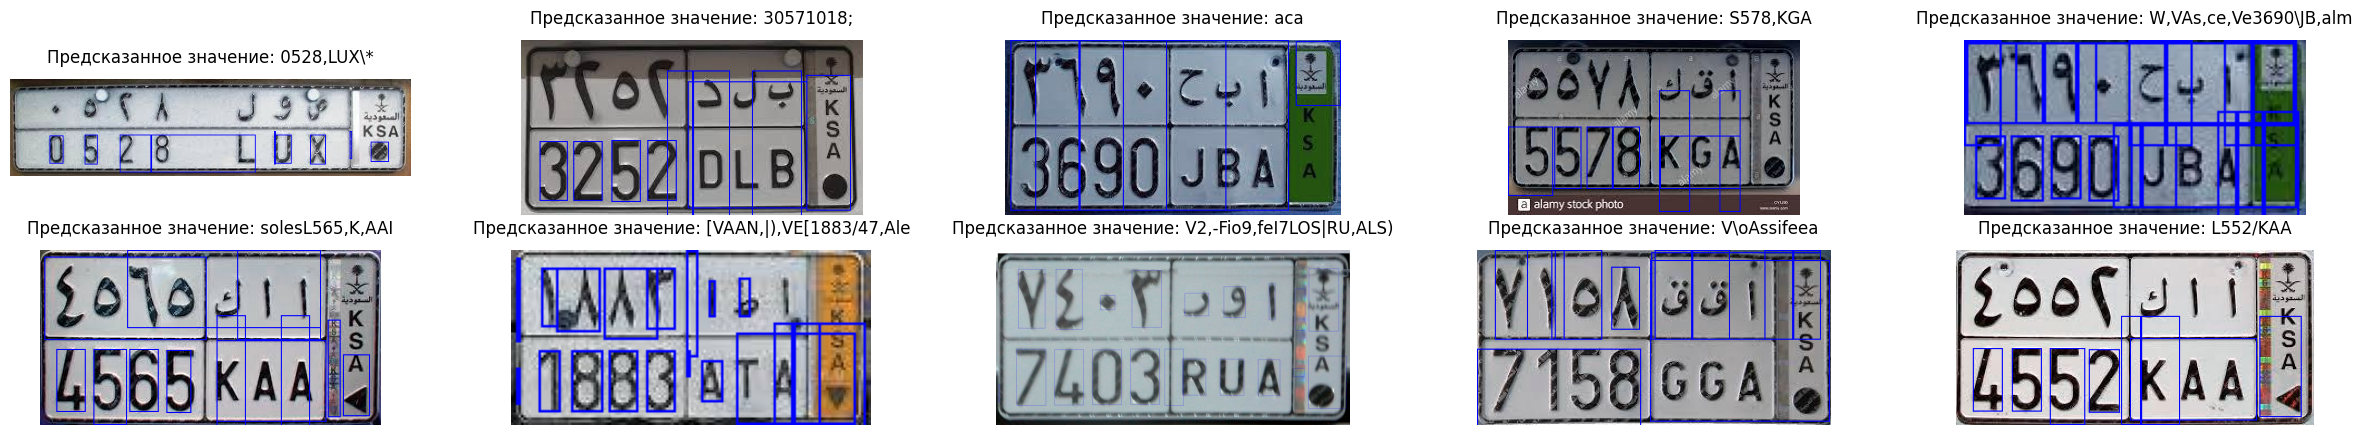

In [79]:
visualize_base_tesseract_preds(train_jpeg_files)

**Вывод** по модели Tesseract_base: Предсказания очень плохие, возможно из-за маленького размера изображений.

## Базовая модель EasyOCR

In [18]:
img = cv2.imread(train_jpeg_files[0])
reader.readtext(img)[4]
cv2.rectangle(img, reader.readtext(img)[4][0])
plt.imshow(img)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - rectangle() missing required argument 'pt2' (pos 3)
>  - rectangle() missing required argument 'pt2' (pos 3)
>  - rectangle() missing required argument 'color' (pos 3)
>  - rectangle() missing required argument 'color' (pos 3)


# Обучение модели

# Тестирование модели